---
## 1️⃣ Setup

In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
else:
    print("GPU not available.")

GPU Available: True
GPU Device: Tesla T4


In [19]:
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pickle
import json
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [3]:
def init_csv_logger(csv_path):
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch",
            "train_loss",
            "train_accuracy",
            "val_loss",
            "val_accuracy"
        ])

def log_epoch_csv(csv_path, epoch, train_loss, train_acc, val_loss, val_acc):
    with open(csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch,
            train_loss,
            train_acc,
            val_loss,
            val_acc
        ])

---
## 2️⃣ Configuration

In [4]:
class Config:
    RANDOM_SEED = 42

    DATASET = 'CIFAR-100'
    NUM_CLASSES = 100
    MEAN = (0.5071, 0.4867, 0.4408)
    STD = (0.2675, 0.2565, 0.2761)

    BATCH_SIZE = 128
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.1
    MOMENTUM=0.9
    WEIGHT_DECAY=5e-4
    DROPOUT_RATE = 0.2

    MODEL_ARCH = 'CustomCNN'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()
print("Configuration:")
print(f"  Device: {config.DEVICE}")
print(f"  Batch Size: {config.BATCH_SIZE}")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Random Seed: {config.RANDOM_SEED}")

Configuration:
  Device: cuda
  Batch Size: 128
  Epochs: 50
  Random Seed: 42


In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.RANDOM_SEED)

---
## 3️⃣ Model Architecture (CustomCNN)

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=100, dropout_rate=config.DROPOUT_RATE):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model = CustomCNN(num_classes=100, dropout_rate=config.DROPOUT_RATE)
num_params = sum(p.numel() for p in model.parameters())
print(f"CustomCNN created")
print(f"  Parameters: {num_params:,}")

x_test = torch.randn(2, 3, 32, 32)
y_test = model(x_test)
print(f"  Input: {x_test.shape} → Output: {y_test.shape}")

CustomCNN created
  Parameters: 10,462,756
  Input: torch.Size([2, 3, 32, 32]) → Output: torch.Size([2, 100])


---
## 4️⃣ Data Loading

In [7]:
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

def denormalize(tensor):
    device = tensor.device
    mean = torch.tensor(config.MEAN).view(3, 1, 1).to(device)
    std = torch.tensor(config.STD).view(3, 1, 1).to(device)
    return tensor * std + mean

In [8]:
def get_cifar100_dataloaders(batch_size=128, augmentation=False, validation_split=0.2):
    normalize = transforms.Normalize(mean=config.MEAN, std=config.STD)

    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    full_train_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=train_transform
    )

    test_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=test_transform
    )

    num_train = len(full_train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_split * num_train))

    np.random.seed(config.RANDOM_SEED)
    np.random.shuffle(indices)

    train_idx, val_idx = indices[split:], indices[:split]

    val_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=test_transform
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(val_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_cifar100_dataloaders(
    batch_size=config.BATCH_SIZE,
    augmentation=False
)

print(f"  Train samples: {len(train_loader.dataset)}")
print(f"  Val samples: {len(val_loader.dataset)}")
print(f"  Test samples: {len(test_loader.dataset)}")

  Train samples: 40000
  Val samples: 10000
  Test samples: 10000


---
## 5️⃣ Baseline Training

In [15]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.LEARNING_RATE,
            momentum=config.MOMENTUM,
            weight_decay=config.WEIGHT_DECAY
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=config.NUM_EPOCHS
        )

        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rate': []
        }

        self.best_val_acc = 0.0
        self.last_val_preds = None
        self.last_val_targets = None

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')

        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': running_loss / total,
                'acc': 100. * correct / total
            })

        return running_loss / total, 100. * correct / total

    def validate(self, loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * labels.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_preds.append(predicted.cpu())
                all_targets.append(labels.cpu())
                
            avg_loss = running_loss / total
            accuracy = 100.0 * correct / total
            preds = torch.cat(all_preds).numpy()
            targets = torch.cat(all_targets).numpy()
            
        return avg_loss, accuracy, preds, targets

    def train(self, num_epochs, model_type):
        print(f"\nTraining CustomCNN on CIFAR-100")
        print(f"Device: {self.device}")
        print(f"Epochs: {num_epochs}")
        print("="*60)

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, val_preds, val_targets = self.validate(self.val_loader)

            self.scheduler.step()

            current_lr = self.optimizer.param_groups[0]['lr']

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rate'].append(current_lr)
            
            self.last_val_preds = val_preds
            self.last_val_targets = val_targets
            
            if model_type == "baseline_model":
              log_epoch_csv(
                      baseline_csv,
                      epoch,
                      train_loss,
                      train_acc,
                      val_loss,
                      val_acc
                  )
            else:
              log_epoch_csv(
                      improved_csv,
                      epoch,
                      train_loss,
                      train_acc,
                      val_loss,
                      val_acc
                  )
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            print(f"Learning Rate: {current_lr:.6f}")

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_model.pth')
                print(f"✓ New best val acc: {val_acc:.2f}%")

        print(f"\nTraining completed!")
        print(f"Best validation accuracy: {self.best_val_acc:.2f}%")

    def test(self):
        test_loss, test_acc, test_preds, test_targets  = self.validate(self.test_loader)
        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.2f}%")
        return test_loss, test_acc, test_preds, test_targets


In [16]:
baseline_csv = "baseline_epoch_log.csv"
init_csv_logger(baseline_csv)
model = CustomCNN(num_classes=100, dropout_rate=config.DROPOUT_RATE)
trainer = Trainer(model, train_loader, val_loader, test_loader, config.DEVICE)

trainer.train(config.NUM_EPOCHS, "baseline_model")

test_loss, test_acc, test_preds, test_targets = trainer.test()

with open('baseline_history.pkl', 'wb') as f:
    pickle.dump(trainer.history, f)


Training CustomCNN on CIFAR-100
Device: cuda
Epochs: 50

Epoch 1/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.63it/s, loss=4.31, acc=4.13]


Train Loss: 4.3098 | Train Acc: 4.13%
Val Loss: 4.1560 | Val Acc: 5.40%
Learning Rate: 0.099901
✓ New best val acc: 5.40%

Epoch 2/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.21it/s, loss=4.08, acc=7.04]


Train Loss: 4.0784 | Train Acc: 7.04%
Val Loss: 4.1401 | Val Acc: 6.65%
Learning Rate: 0.099606
✓ New best val acc: 6.65%

Epoch 3/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.43it/s, loss=3.88, acc=10.6]


Train Loss: 3.8818 | Train Acc: 10.60%
Val Loss: 3.7717 | Val Acc: 12.44%
Learning Rate: 0.099114
✓ New best val acc: 12.44%

Epoch 4/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.66it/s, loss=3.66, acc=15.6]


Train Loss: 3.6574 | Train Acc: 15.55%
Val Loss: 3.6464 | Val Acc: 16.79%
Learning Rate: 0.098429
✓ New best val acc: 16.79%

Epoch 5/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.68it/s, loss=3.41, acc=21.1]


Train Loss: 3.4115 | Train Acc: 21.08%
Val Loss: 3.4483 | Val Acc: 20.18%
Learning Rate: 0.097553
✓ New best val acc: 20.18%

Epoch 6/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.57it/s, loss=3.18, acc=26.7]


Train Loss: 3.1834 | Train Acc: 26.65%
Val Loss: 3.2368 | Val Acc: 25.92%
Learning Rate: 0.096489
✓ New best val acc: 25.92%

Epoch 7/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.46it/s, loss=3, acc=31.5]   


Train Loss: 2.9956 | Train Acc: 31.51%
Val Loss: 3.1392 | Val Acc: 28.76%
Learning Rate: 0.095241
✓ New best val acc: 28.76%

Epoch 8/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.56it/s, loss=2.82, acc=36.3]


Train Loss: 2.8188 | Train Acc: 36.26%
Val Loss: 3.1284 | Val Acc: 29.75%
Learning Rate: 0.093815
✓ New best val acc: 29.75%

Epoch 9/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.62it/s, loss=2.69, acc=40.1]


Train Loss: 2.6877 | Train Acc: 40.12%
Val Loss: 2.9904 | Val Acc: 33.74%
Learning Rate: 0.092216
✓ New best val acc: 33.74%

Epoch 10/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.57it/s, loss=2.57, acc=43.6]


Train Loss: 2.5657 | Train Acc: 43.59%
Val Loss: 2.9367 | Val Acc: 34.58%
Learning Rate: 0.090451
✓ New best val acc: 34.58%

Epoch 11/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.53it/s, loss=2.46, acc=47]  


Train Loss: 2.4566 | Train Acc: 47.03%
Val Loss: 2.6440 | Val Acc: 41.87%
Learning Rate: 0.088526
✓ New best val acc: 41.87%

Epoch 12/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.56it/s, loss=2.37, acc=49.5]


Train Loss: 2.3656 | Train Acc: 49.52%
Val Loss: 2.6383 | Val Acc: 41.86%
Learning Rate: 0.086448

Epoch 13/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=2.28, acc=52.2]


Train Loss: 2.2829 | Train Acc: 52.20%
Val Loss: 2.7753 | Val Acc: 40.57%
Learning Rate: 0.084227

Epoch 14/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=2.17, acc=55.5]


Train Loss: 2.1736 | Train Acc: 55.47%
Val Loss: 2.8307 | Val Acc: 40.05%
Learning Rate: 0.081871

Epoch 15/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.61it/s, loss=2.09, acc=57.9]


Train Loss: 2.0902 | Train Acc: 57.92%
Val Loss: 2.6236 | Val Acc: 43.83%
Learning Rate: 0.079389
✓ New best val acc: 43.83%

Epoch 16/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.62it/s, loss=1.99, acc=61.3]


Train Loss: 1.9928 | Train Acc: 61.30%
Val Loss: 2.7425 | Val Acc: 41.74%
Learning Rate: 0.076791

Epoch 17/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.58it/s, loss=1.92, acc=63.6]


Train Loss: 1.9165 | Train Acc: 63.65%
Val Loss: 2.6436 | Val Acc: 43.81%
Learning Rate: 0.074088

Epoch 18/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=1.84, acc=66.2]


Train Loss: 1.8377 | Train Acc: 66.22%
Val Loss: 2.5911 | Val Acc: 45.73%
Learning Rate: 0.071289
✓ New best val acc: 45.73%

Epoch 19/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.62it/s, loss=1.74, acc=69.4]


Train Loss: 1.7434 | Train Acc: 69.36%
Val Loss: 2.7030 | Val Acc: 43.70%
Learning Rate: 0.068406

Epoch 20/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=1.67, acc=71.8]


Train Loss: 1.6714 | Train Acc: 71.81%
Val Loss: 2.7240 | Val Acc: 44.54%
Learning Rate: 0.065451

Epoch 21/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=1.58, acc=75.1]


Train Loss: 1.5753 | Train Acc: 75.14%
Val Loss: 2.4481 | Val Acc: 50.51%
Learning Rate: 0.062434
✓ New best val acc: 50.51%

Epoch 22/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.56it/s, loss=1.5, acc=77.8] 


Train Loss: 1.4981 | Train Acc: 77.79%
Val Loss: 2.4628 | Val Acc: 49.97%
Learning Rate: 0.059369

Epoch 23/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.61it/s, loss=1.43, acc=80.2]


Train Loss: 1.4315 | Train Acc: 80.25%
Val Loss: 2.6368 | Val Acc: 46.30%
Learning Rate: 0.056267

Epoch 24/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=1.36, acc=82.8]


Train Loss: 1.3587 | Train Acc: 82.77%
Val Loss: 2.5046 | Val Acc: 50.21%
Learning Rate: 0.053140

Epoch 25/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.58it/s, loss=1.27, acc=86.3]


Train Loss: 1.2662 | Train Acc: 86.29%
Val Loss: 2.4935 | Val Acc: 50.08%
Learning Rate: 0.050000

Epoch 26/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.58it/s, loss=1.19, acc=88.8]


Train Loss: 1.1937 | Train Acc: 88.78%
Val Loss: 2.4761 | Val Acc: 51.08%
Learning Rate: 0.046860
✓ New best val acc: 51.08%

Epoch 27/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.56it/s, loss=1.12, acc=91.7]


Train Loss: 1.1154 | Train Acc: 91.67%
Val Loss: 2.4554 | Val Acc: 52.13%
Learning Rate: 0.043733
✓ New best val acc: 52.13%

Epoch 28/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=1.05, acc=94]  


Train Loss: 1.0534 | Train Acc: 93.99%
Val Loss: 2.3757 | Val Acc: 54.11%
Learning Rate: 0.040631
✓ New best val acc: 54.11%

Epoch 29/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.57it/s, loss=0.978, acc=96.5]


Train Loss: 0.9781 | Train Acc: 96.49%
Val Loss: 2.3267 | Val Acc: 55.40%
Learning Rate: 0.037566
✓ New best val acc: 55.40%

Epoch 30/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.56it/s, loss=0.931, acc=98]  


Train Loss: 0.9312 | Train Acc: 98.03%
Val Loss: 2.2628 | Val Acc: 57.50%
Learning Rate: 0.034549
✓ New best val acc: 57.50%

Epoch 31/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=0.884, acc=99.1]


Train Loss: 0.8844 | Train Acc: 99.14%
Val Loss: 2.2112 | Val Acc: 58.52%
Learning Rate: 0.031594
✓ New best val acc: 58.52%

Epoch 32/50


Training: 100%|██████████| 313/313 [00:16<00:00, 19.56it/s, loss=0.856, acc=99.7]


Train Loss: 0.8558 | Train Acc: 99.67%
Val Loss: 2.1631 | Val Acc: 59.75%
Learning Rate: 0.028711
✓ New best val acc: 59.75%

Epoch 33/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.57it/s, loss=0.838, acc=99.9]


Train Loss: 0.8384 | Train Acc: 99.86%
Val Loss: 2.1215 | Val Acc: 60.98%
Learning Rate: 0.025912
✓ New best val acc: 60.98%

Epoch 34/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=0.83, acc=99.9] 


Train Loss: 0.8300 | Train Acc: 99.92%
Val Loss: 2.1094 | Val Acc: 61.59%
Learning Rate: 0.023209
✓ New best val acc: 61.59%

Epoch 35/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.58it/s, loss=0.825, acc=99.9]


Train Loss: 0.8255 | Train Acc: 99.94%
Val Loss: 2.1076 | Val Acc: 61.93%
Learning Rate: 0.020611
✓ New best val acc: 61.93%

Epoch 36/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=0.823, acc=99.9]


Train Loss: 0.8227 | Train Acc: 99.94%
Val Loss: 2.1081 | Val Acc: 61.92%
Learning Rate: 0.018129

Epoch 37/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=0.82, acc=100] 


Train Loss: 0.8203 | Train Acc: 99.96%
Val Loss: 2.1166 | Val Acc: 61.99%
Learning Rate: 0.015773
✓ New best val acc: 61.99%

Epoch 38/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.61it/s, loss=0.818, acc=100]


Train Loss: 0.8182 | Train Acc: 99.96%
Val Loss: 2.1194 | Val Acc: 61.90%
Learning Rate: 0.013552

Epoch 39/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.62it/s, loss=0.817, acc=100]


Train Loss: 0.8169 | Train Acc: 99.97%
Val Loss: 2.1245 | Val Acc: 62.24%
Learning Rate: 0.011474
✓ New best val acc: 62.24%

Epoch 40/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=0.815, acc=100]


Train Loss: 0.8153 | Train Acc: 99.98%
Val Loss: 2.1268 | Val Acc: 62.21%
Learning Rate: 0.009549

Epoch 41/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=0.814, acc=100]


Train Loss: 0.8145 | Train Acc: 99.98%
Val Loss: 2.1297 | Val Acc: 62.22%
Learning Rate: 0.007784

Epoch 42/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=0.814, acc=100]


Train Loss: 0.8138 | Train Acc: 99.98%
Val Loss: 2.1294 | Val Acc: 62.11%
Learning Rate: 0.006185

Epoch 43/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=0.813, acc=100]


Train Loss: 0.8129 | Train Acc: 99.98%
Val Loss: 2.1337 | Val Acc: 61.89%
Learning Rate: 0.004759

Epoch 44/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.58it/s, loss=0.812, acc=100]


Train Loss: 0.8124 | Train Acc: 99.98%
Val Loss: 2.1401 | Val Acc: 62.02%
Learning Rate: 0.003511

Epoch 45/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=0.812, acc=100]


Train Loss: 0.8121 | Train Acc: 99.98%
Val Loss: 2.1395 | Val Acc: 62.17%
Learning Rate: 0.002447

Epoch 46/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=0.812, acc=100]


Train Loss: 0.8120 | Train Acc: 99.99%
Val Loss: 2.1408 | Val Acc: 62.02%
Learning Rate: 0.001571

Epoch 47/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.61it/s, loss=0.811, acc=100]


Train Loss: 0.8114 | Train Acc: 99.99%
Val Loss: 2.1403 | Val Acc: 62.00%
Learning Rate: 0.000886

Epoch 48/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.59it/s, loss=0.811, acc=100]


Train Loss: 0.8112 | Train Acc: 99.98%
Val Loss: 2.1437 | Val Acc: 61.97%
Learning Rate: 0.000394

Epoch 49/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=0.811, acc=100]


Train Loss: 0.8113 | Train Acc: 99.98%
Val Loss: 2.1424 | Val Acc: 62.11%
Learning Rate: 0.000099

Epoch 50/50


Training: 100%|██████████| 313/313 [00:15<00:00, 19.60it/s, loss=0.811, acc=100]


Train Loss: 0.8113 | Train Acc: 99.99%
Val Loss: 2.1405 | Val Acc: 62.17%
Learning Rate: 0.000000

Training completed!
Best validation accuracy: 62.24%

Test Loss: 2.1251
Test Accuracy: 62.91%


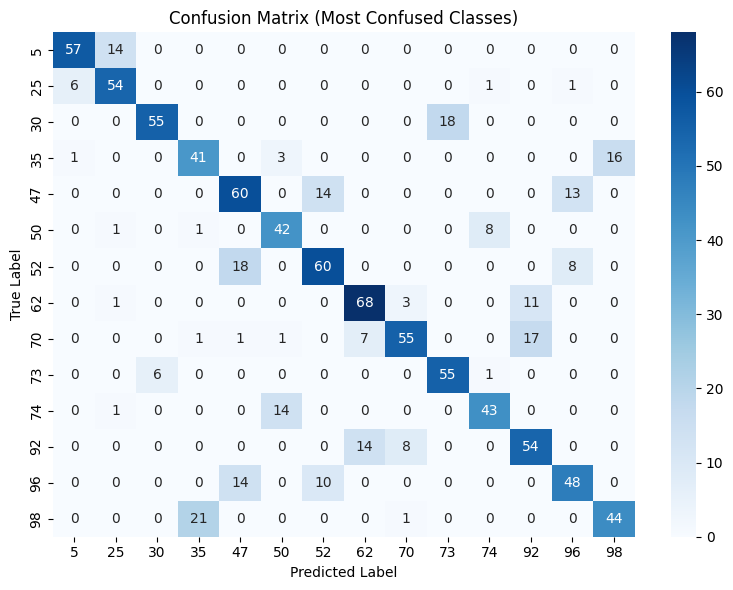

In [22]:
top_classes = np.unique([i for i, j in pairs] + [j for i, j in pairs])

cm_subset = cm[np.ix_(top_classes, top_classes)]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_subset,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=top_classes,
    yticklabels=top_classes
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Most Confused Classes)")
plt.tight_layout()
plt.savefig("confusion_matrix_baseline.png", dpi=300)
plt.show()

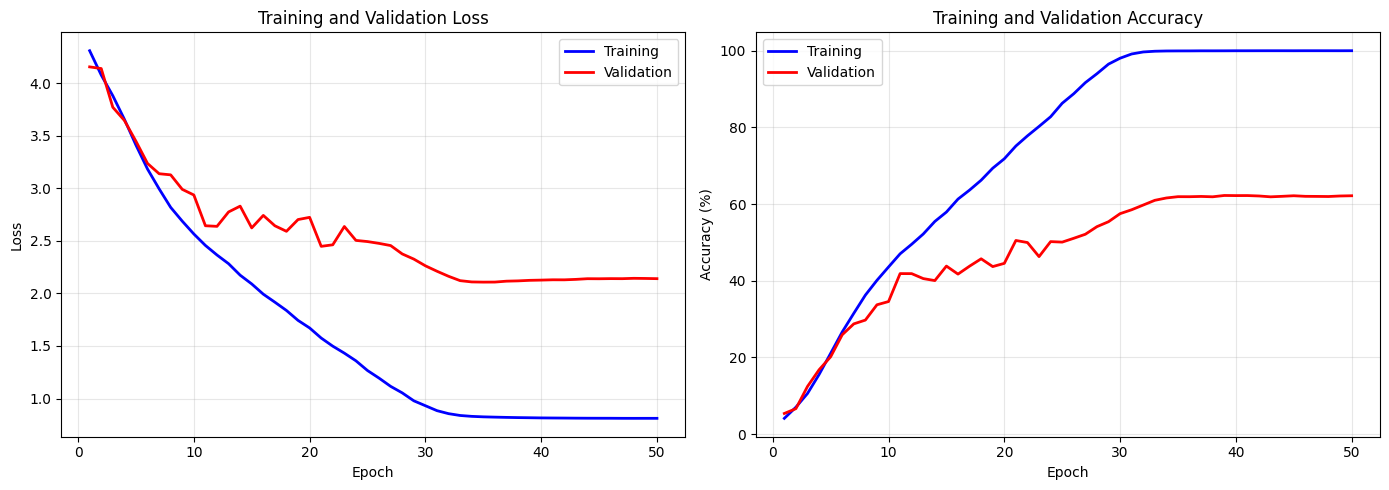

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(trainer.history['train_loss']) + 1)

axes[0].plot(epochs, trainer.history['train_loss'], 'b-', label='Training', linewidth=2)
axes[0].plot(epochs, trainer.history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs, trainer.history['train_acc'], 'b-', label='Training', linewidth=2)
axes[1].plot(epochs, trainer.history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6️⃣ Failure Analysis

In [24]:
def find_failures(model, test_loader, device, min_confidence=0.8):
    model.eval()
    failures = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Finding failures"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            confidences, predictions = probs.max(1)

            incorrect = predictions.ne(labels)
            high_conf = confidences >= min_confidence
            failure_mask = incorrect & high_conf

            for idx in failure_mask.nonzero(as_tuple=True)[0]:
                failures.append({
                    'image': images[idx].cpu(),
                    'true_label': labels[idx].item(),
                    'pred_label': predictions[idx].item(),
                    'confidence': confidences[idx].item(),
                    'true_class': CIFAR100_CLASSES[labels[idx].item()],
                    'pred_class': CIFAR100_CLASSES[predictions[idx].item()]
                })

    return failures

model.load_state_dict(torch.load('best_model.pth'))
model = model.to(config.DEVICE)

failures = find_failures(model, test_loader, config.DEVICE)
print(f"\nFound {len(failures)} high-confidence failures")

Finding failures: 100%|██████████| 79/79 [00:01<00:00, 45.15it/s]


Found 138 high-confidence failures


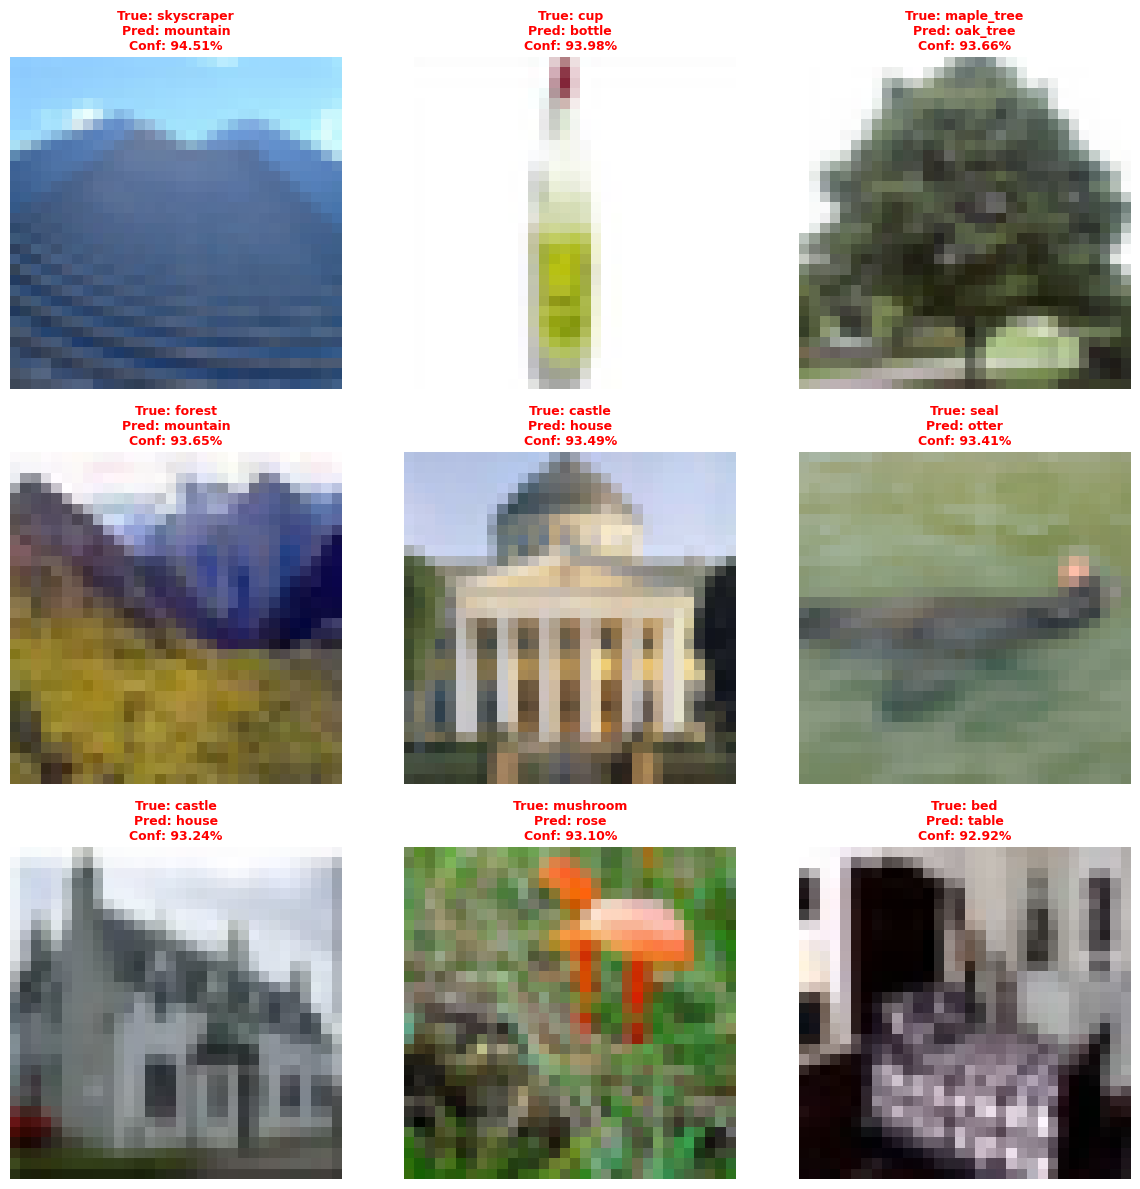

In [25]:
def plot_failures(failures, num_show=9):
    num_show = min(num_show, len(failures))
    rows = 3
    cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_show):
        img = denormalize(failures[i]['image']).numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].axis('off')

        title = f"True: {failures[i]['true_class']}\n"
        title += f"Pred: {failures[i]['pred_class']}\n"
        title += f"Conf: {failures[i]['confidence']:.2%}"
        axes[i].set_title(title, fontsize=9, color='red', fontweight='bold')

    for i in range(num_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('failure_cases.png', dpi=300, bbox_inches='tight')
    plt.show()

failures = sorted(
    failures,
    key=lambda x: x['confidence'],
    reverse=True
)
plot_failures(failures)

---
## 7️⃣ Explainability (Grad-CAM)

In [26]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_image, target_class):
        self.model.zero_grad()
        output = self.model(input_image)
        score = output[:, target_class].sum()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1))

        cam = cam.squeeze()
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.detach().cpu().numpy()

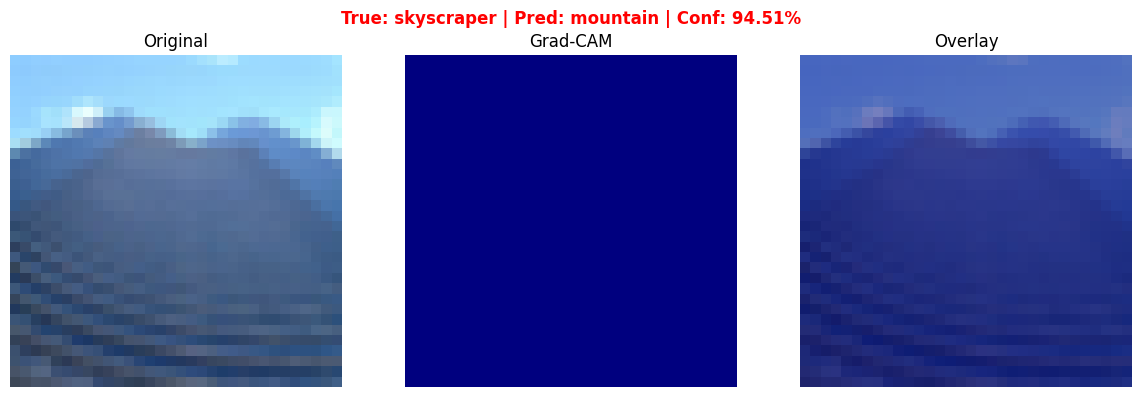

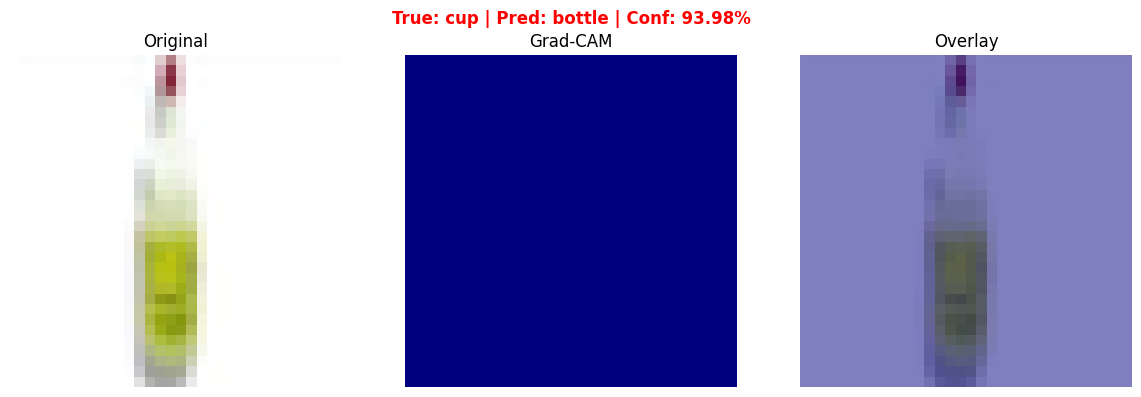

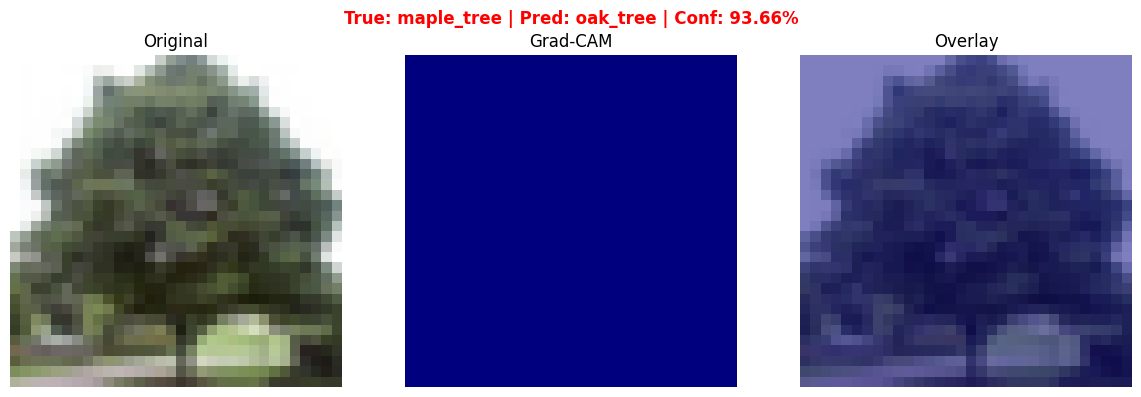

In [27]:
def visualize_gradcam(failure, model):
    gradcam = GradCAM(model, model.features[-4])

    image_batch = failure['image'].unsqueeze(0).to(config.DEVICE)
    cam = gradcam.generate_cam(image_batch, target_class=failure['pred_label'])

    img = denormalize(failure['image']).numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)

    cam_resized = cv2.resize(cam, (32, 32))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    overlayed = heatmap * 0.5 + img * 0.5

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    axes[2].imshow(overlayed)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    title = f"True: {failure['true_class']} | Pred: {failure['pred_class']} | Conf: {failure['confidence']:.2%}"
    fig.suptitle(title, fontsize=12, fontweight='bold', color='red')

    plt.tight_layout()
    return fig

for i in range(min(3, len(failures))):
    fig = visualize_gradcam(failures[i], model)
    plt.savefig(f'gradcam_failure_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

---
## 8️⃣ Improvement Experiment

**Choose ONE improvement type**

In [30]:
IMPROVEMENT_TYPE = 'augmentation'

train_loader_imp, val_loader_imp, test_loader_imp = get_cifar100_dataloaders(
    batch_size=config.BATCH_SIZE, augmentation=True
)

model_imp = CustomCNN(num_classes=100, dropout_rate=config.DROPOUT_RATE)

class ImprovedTrainer(Trainer):
    def __init__(self, model, train_loader, val_loader, test_loader, device):
        super().__init__(model, train_loader, val_loader, test_loader, device)

trainer_imp = ImprovedTrainer(
    model_imp, train_loader_imp, val_loader_imp, test_loader_imp,
    config.DEVICE
)

improved_csv = "improved_epoch_log.csv"
init_csv_logger(improved_csv)

print(f"\nTraining improved model with {IMPROVEMENT_TYPE}...")
trainer_imp.train(config.NUM_EPOCHS, "improved_model")

test_loss_imp, test_acc_imp, test_preds, test_targets= trainer_imp.test()



Training improved model with augmentation...

Training CustomCNN on CIFAR-100
Device: cuda
Epochs: 50

Epoch 1/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s, loss=4.43, acc=2.62]


Train Loss: 4.4310 | Train Acc: 2.62%
Val Loss: 4.2343 | Val Acc: 4.59%
Learning Rate: 0.099901
✓ New best val acc: 4.59%

Epoch 2/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s, loss=4.22, acc=5.09]


Train Loss: 4.2155 | Train Acc: 5.09%
Val Loss: 4.0849 | Val Acc: 6.36%
Learning Rate: 0.099606
✓ New best val acc: 6.36%

Epoch 3/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s, loss=4.09, acc=6.91]


Train Loss: 4.0949 | Train Acc: 6.91%
Val Loss: 4.0555 | Val Acc: 7.72%
Learning Rate: 0.099114
✓ New best val acc: 7.72%

Epoch 4/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s, loss=3.95, acc=9.48]


Train Loss: 3.9549 | Train Acc: 9.48%
Val Loss: 3.9494 | Val Acc: 9.38%
Learning Rate: 0.098429
✓ New best val acc: 9.38%

Epoch 5/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s, loss=3.78, acc=13.1]


Train Loss: 3.7770 | Train Acc: 13.10%
Val Loss: 3.7000 | Val Acc: 15.19%
Learning Rate: 0.097553
✓ New best val acc: 15.19%

Epoch 6/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s, loss=3.59, acc=17.1]


Train Loss: 3.5887 | Train Acc: 17.07%
Val Loss: 3.6433 | Val Acc: 16.23%
Learning Rate: 0.096489
✓ New best val acc: 16.23%

Epoch 7/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s, loss=3.42, acc=20.7]


Train Loss: 3.4210 | Train Acc: 20.65%
Val Loss: 3.6643 | Val Acc: 17.12%
Learning Rate: 0.095241
✓ New best val acc: 17.12%

Epoch 8/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s, loss=3.29, acc=24.1]


Train Loss: 3.2903 | Train Acc: 24.05%
Val Loss: 3.6224 | Val Acc: 19.08%
Learning Rate: 0.093815
✓ New best val acc: 19.08%

Epoch 9/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s, loss=3.16, acc=27.2]


Train Loss: 3.1590 | Train Acc: 27.22%
Val Loss: 3.1436 | Val Acc: 28.65%
Learning Rate: 0.092216
✓ New best val acc: 28.65%

Epoch 10/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s, loss=3.03, acc=30.8]


Train Loss: 3.0282 | Train Acc: 30.82%
Val Loss: 3.1291 | Val Acc: 28.16%
Learning Rate: 0.090451

Epoch 11/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s, loss=2.94, acc=33.3]


Train Loss: 2.9405 | Train Acc: 33.31%
Val Loss: 3.1938 | Val Acc: 27.82%
Learning Rate: 0.088526

Epoch 12/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s, loss=2.85, acc=35.8]


Train Loss: 2.8522 | Train Acc: 35.79%
Val Loss: 3.0174 | Val Acc: 31.85%
Learning Rate: 0.086448
✓ New best val acc: 31.85%

Epoch 13/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s, loss=2.77, acc=38.2]


Train Loss: 2.7716 | Train Acc: 38.23%
Val Loss: 3.0106 | Val Acc: 32.97%
Learning Rate: 0.084227
✓ New best val acc: 32.97%

Epoch 14/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.70it/s, loss=2.69, acc=40.2]


Train Loss: 2.6927 | Train Acc: 40.21%
Val Loss: 2.8183 | Val Acc: 38.24%
Learning Rate: 0.081871
✓ New best val acc: 38.24%

Epoch 15/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.73it/s, loss=2.63, acc=42]  


Train Loss: 2.6272 | Train Acc: 42.02%
Val Loss: 2.6743 | Val Acc: 41.39%
Learning Rate: 0.079389
✓ New best val acc: 41.39%

Epoch 16/50


Training: 100%|██████████| 313/313 [00:20<00:00, 15.59it/s, loss=2.56, acc=44.3]


Train Loss: 2.5613 | Train Acc: 44.26%
Val Loss: 2.9661 | Val Acc: 35.53%
Learning Rate: 0.076791

Epoch 17/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s, loss=2.51, acc=45.6]


Train Loss: 2.5109 | Train Acc: 45.57%
Val Loss: 2.8367 | Val Acc: 38.50%
Learning Rate: 0.074088

Epoch 18/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s, loss=2.45, acc=47.7]


Train Loss: 2.4483 | Train Acc: 47.71%
Val Loss: 2.7074 | Val Acc: 41.84%
Learning Rate: 0.071289
✓ New best val acc: 41.84%

Epoch 19/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s, loss=2.41, acc=48.8]


Train Loss: 2.4063 | Train Acc: 48.76%
Val Loss: 2.4968 | Val Acc: 46.57%
Learning Rate: 0.068406
✓ New best val acc: 46.57%

Epoch 20/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s, loss=2.35, acc=50.6]


Train Loss: 2.3472 | Train Acc: 50.63%
Val Loss: 2.4578 | Val Acc: 47.38%
Learning Rate: 0.065451
✓ New best val acc: 47.38%

Epoch 21/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s, loss=2.3, acc=52.1] 


Train Loss: 2.3029 | Train Acc: 52.06%
Val Loss: 2.6867 | Val Acc: 42.63%
Learning Rate: 0.062434

Epoch 22/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s, loss=2.24, acc=53.8]


Train Loss: 2.2415 | Train Acc: 53.84%
Val Loss: 2.4701 | Val Acc: 47.47%
Learning Rate: 0.059369
✓ New best val acc: 47.47%

Epoch 23/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s, loss=2.2, acc=55]   


Train Loss: 2.2046 | Train Acc: 54.98%
Val Loss: 2.4515 | Val Acc: 47.82%
Learning Rate: 0.056267
✓ New best val acc: 47.82%

Epoch 24/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s, loss=2.15, acc=56.5]


Train Loss: 2.1510 | Train Acc: 56.49%
Val Loss: 2.7154 | Val Acc: 43.06%
Learning Rate: 0.053140

Epoch 25/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.76it/s, loss=2.12, acc=57.5]


Train Loss: 2.1178 | Train Acc: 57.49%
Val Loss: 2.4187 | Val Acc: 50.00%
Learning Rate: 0.050000
✓ New best val acc: 50.00%

Epoch 26/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s, loss=2.07, acc=59.2]


Train Loss: 2.0685 | Train Acc: 59.24%
Val Loss: 2.5426 | Val Acc: 48.78%
Learning Rate: 0.046860

Epoch 27/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s, loss=2.02, acc=60.5]


Train Loss: 2.0231 | Train Acc: 60.53%
Val Loss: 2.2823 | Val Acc: 53.22%
Learning Rate: 0.043733
✓ New best val acc: 53.22%

Epoch 28/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s, loss=1.97, acc=62.1]


Train Loss: 1.9712 | Train Acc: 62.09%
Val Loss: 2.1861 | Val Acc: 55.86%
Learning Rate: 0.040631
✓ New best val acc: 55.86%

Epoch 29/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s, loss=1.92, acc=63.9]


Train Loss: 1.9187 | Train Acc: 63.86%
Val Loss: 2.2401 | Val Acc: 54.62%
Learning Rate: 0.037566

Epoch 30/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s, loss=1.88, acc=65]  


Train Loss: 1.8772 | Train Acc: 64.95%
Val Loss: 2.1691 | Val Acc: 56.29%
Learning Rate: 0.034549
✓ New best val acc: 56.29%

Epoch 31/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s, loss=1.83, acc=66.6]


Train Loss: 1.8261 | Train Acc: 66.61%
Val Loss: 2.1526 | Val Acc: 57.41%
Learning Rate: 0.031594
✓ New best val acc: 57.41%

Epoch 32/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s, loss=1.76, acc=68.7]


Train Loss: 1.7635 | Train Acc: 68.65%
Val Loss: 2.1204 | Val Acc: 57.86%
Learning Rate: 0.028711
✓ New best val acc: 57.86%

Epoch 33/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s, loss=1.71, acc=70.3]


Train Loss: 1.7130 | Train Acc: 70.31%
Val Loss: 2.2502 | Val Acc: 55.56%
Learning Rate: 0.025912

Epoch 34/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s, loss=1.67, acc=71.5]


Train Loss: 1.6733 | Train Acc: 71.47%
Val Loss: 2.0534 | Val Acc: 59.52%
Learning Rate: 0.023209
✓ New best val acc: 59.52%

Epoch 35/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.27it/s, loss=1.62, acc=73.3]


Train Loss: 1.6169 | Train Acc: 73.33%
Val Loss: 2.0172 | Val Acc: 61.35%
Learning Rate: 0.020611
✓ New best val acc: 61.35%

Epoch 36/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s, loss=1.56, acc=75.3]


Train Loss: 1.5609 | Train Acc: 75.29%
Val Loss: 1.9630 | Val Acc: 62.68%
Learning Rate: 0.018129
✓ New best val acc: 62.68%

Epoch 37/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s, loss=1.5, acc=77.1] 


Train Loss: 1.5034 | Train Acc: 77.11%
Val Loss: 2.0622 | Val Acc: 59.85%
Learning Rate: 0.015773

Epoch 38/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s, loss=1.45, acc=79]  


Train Loss: 1.4473 | Train Acc: 78.97%
Val Loss: 1.9225 | Val Acc: 64.45%
Learning Rate: 0.013552
✓ New best val acc: 64.45%

Epoch 39/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.16it/s, loss=1.39, acc=81]  


Train Loss: 1.3921 | Train Acc: 81.01%
Val Loss: 1.9166 | Val Acc: 64.98%
Learning Rate: 0.011474
✓ New best val acc: 64.98%

Epoch 40/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s, loss=1.34, acc=82.9]


Train Loss: 1.3381 | Train Acc: 82.87%
Val Loss: 1.8886 | Val Acc: 65.81%
Learning Rate: 0.009549
✓ New best val acc: 65.81%

Epoch 41/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.91it/s, loss=1.28, acc=85.1]


Train Loss: 1.2783 | Train Acc: 85.09%
Val Loss: 1.8539 | Val Acc: 66.64%
Learning Rate: 0.007784
✓ New best val acc: 66.64%

Epoch 42/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s, loss=1.23, acc=86.8]


Train Loss: 1.2324 | Train Acc: 86.78%
Val Loss: 1.8461 | Val Acc: 66.98%
Learning Rate: 0.006185
✓ New best val acc: 66.98%

Epoch 43/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s, loss=1.19, acc=88.2]


Train Loss: 1.1912 | Train Acc: 88.20%
Val Loss: 1.8123 | Val Acc: 68.29%
Learning Rate: 0.004759
✓ New best val acc: 68.29%

Epoch 44/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s, loss=1.15, acc=90]  


Train Loss: 1.1454 | Train Acc: 89.97%
Val Loss: 1.8039 | Val Acc: 68.65%
Learning Rate: 0.003511
✓ New best val acc: 68.65%

Epoch 45/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s, loss=1.11, acc=91.4]


Train Loss: 1.1124 | Train Acc: 91.42%
Val Loss: 1.8010 | Val Acc: 68.71%
Learning Rate: 0.002447
✓ New best val acc: 68.71%

Epoch 46/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s, loss=1.09, acc=92.4]


Train Loss: 1.0890 | Train Acc: 92.36%
Val Loss: 1.7865 | Val Acc: 69.03%
Learning Rate: 0.001571
✓ New best val acc: 69.03%

Epoch 47/50


Training: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s, loss=1.07, acc=93.1]


Train Loss: 1.0682 | Train Acc: 93.08%
Val Loss: 1.7762 | Val Acc: 69.32%
Learning Rate: 0.000886
✓ New best val acc: 69.32%

Epoch 48/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.26it/s, loss=1.05, acc=93.6]


Train Loss: 1.0534 | Train Acc: 93.56%
Val Loss: 1.7673 | Val Acc: 69.74%
Learning Rate: 0.000394
✓ New best val acc: 69.74%

Epoch 49/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.15it/s, loss=1.05, acc=93.9]


Train Loss: 1.0472 | Train Acc: 93.88%
Val Loss: 1.7690 | Val Acc: 69.56%
Learning Rate: 0.000099

Epoch 50/50


Training: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s, loss=1.04, acc=94.1]


Train Loss: 1.0415 | Train Acc: 94.10%
Val Loss: 1.7666 | Val Acc: 69.75%
Learning Rate: 0.000000
✓ New best val acc: 69.75%

Training completed!
Best validation accuracy: 69.75%

Test Loss: 1.7868
Test Accuracy: 69.53%


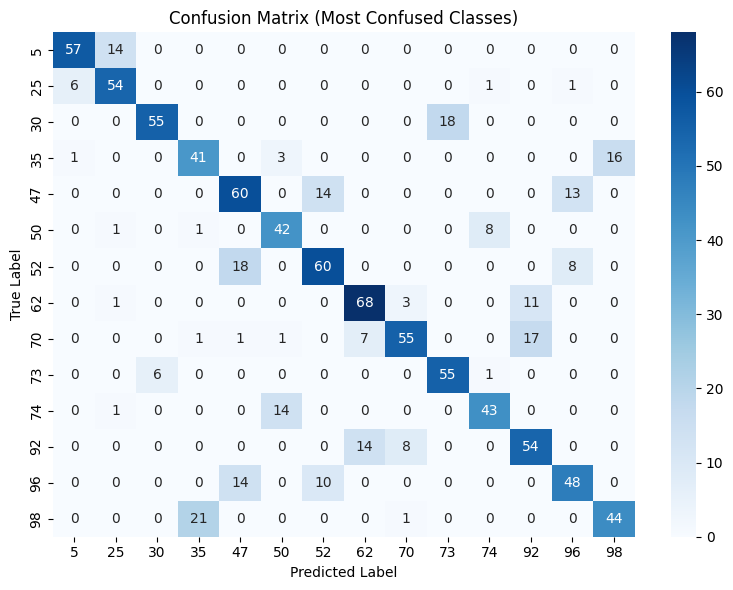

In [1]:
top_classes = np.unique([i for i, j in pairs] + [j for i, j in pairs])

cm_subset = cm[np.ix_(top_classes, top_classes)]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_subset,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=top_classes,
    yticklabels=top_classes
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Most Confused Classes)")
plt.tight_layout()
plt.savefig("confusion_matrix_improved.png", dpi=300)
plt.show()

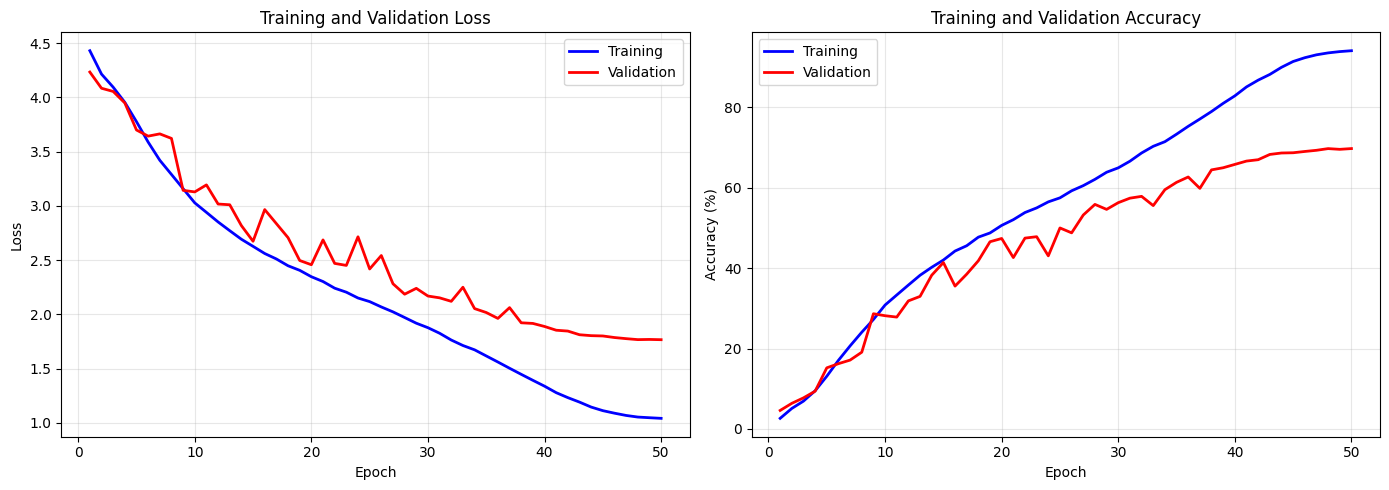

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(trainer_imp.history['train_loss']) + 1)

axes[0].plot(epochs, trainer_imp.history['train_loss'], 'b-', label='Training', linewidth=2)
axes[0].plot(epochs, trainer_imp.history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs, trainer_imp.history['train_acc'], 'b-', label='Training', linewidth=2)
axes[1].plot(epochs, trainer_imp.history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 9️⃣ Evaluation & Comparison


COMPARISON: BASELINE vs IMPROVED

Baseline Test Accuracy: 62.91%
Improved Test Accuracy: 69.53%
Difference: +6.62%


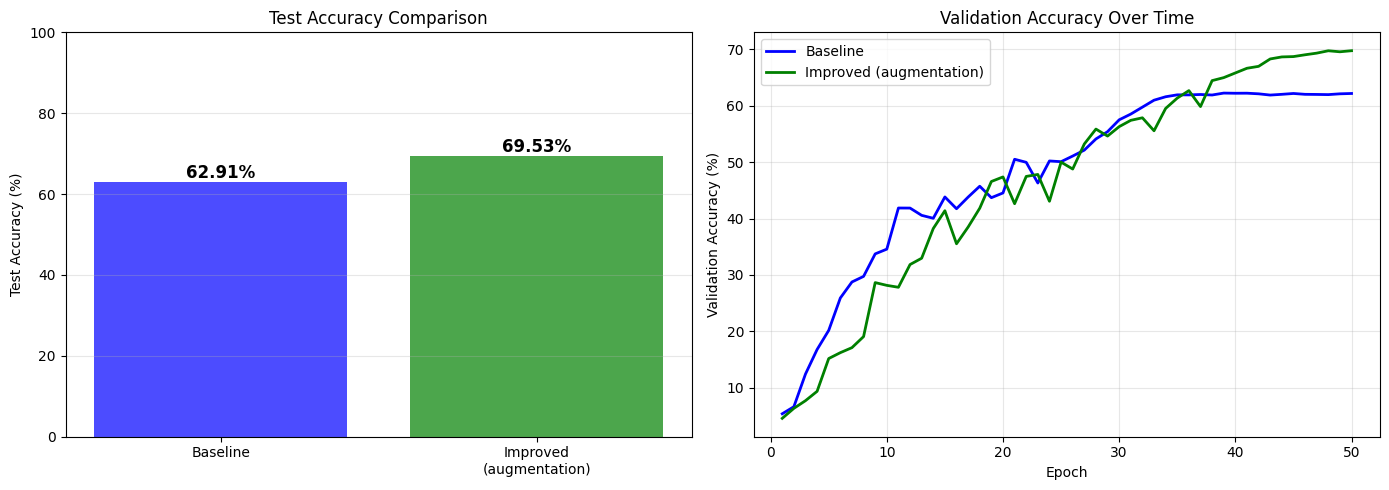

In [3]:
print("\n" + "="*60)
print("COMPARISON: BASELINE vs IMPROVED")
print("="*60)
print(f"\nBaseline Test Accuracy: {test_acc:.2f}%")
print(f"Improved Test Accuracy: {test_acc_imp:.2f}%")
print(f"Difference: {test_acc_imp - test_acc:+.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Baseline', f'Improved\n({IMPROVEMENT_TYPE})']
accuracies = [test_acc, test_acc_imp]
colors = ['blue', 'green']

axes[0].bar(models, accuracies, color=colors, alpha=0.7)
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

for i, (model, acc) in enumerate(zip(models, accuracies)):
    axes[0].text(i, acc + 1, f'{acc:.2f}%', ha='center', fontsize=12, fontweight='bold')

epochs_baseline = range(1, len(trainer.history['val_acc']) + 1)
epochs_improved = range(1, len(trainer_imp.history['val_acc']) + 1)

axes[1].plot(epochs_baseline, trainer.history['val_acc'], 'b-', label='Baseline', linewidth=2)
axes[1].plot(epochs_improved, trainer_imp.history['val_acc'], 'g-', label=f'Improved ({IMPROVEMENT_TYPE})', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Validation Accuracy Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_vs_improved.png', dpi=300, bbox_inches='tight')
plt.show()